# GA Final Project
##### by Mundy Reimer
_______________

# *notMNIST Classification* # 
_______________

![title](http://yaroslavvb.com/upload/notMNIST/nmn.png)

__________________


**Sources:**

- notMNIST data set [found here](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) .


- With help from TensorFlow tutorials: [Logistic Regression 1](http://nbviewer.jupyter.org/github/jdwittenauer/ipython-notebooks/blob/master/notebooks/tensorflow/Tensorflow-1-NotMNIST.ipynb) + [Simple NN 2](http://nbviewer.jupyter.org/github/jdwittenauer/ipython-notebooks/blob/master/notebooks/tensorflow/Tensorflow-2-FullyConnected.ipynb) + [Regularization Techniques 3](http://nbviewer.jupyter.org/github/jdwittenauer/ipython-notebooks/blob/master/notebooks/tensorflow/Tensorflow-3-Regularization.ipynb) + [Convolutions 4](http://nbviewer.jupyter.org/github/jdwittenauer/ipython-notebooks/blob/master/notebooks/tensorflow/Tensorflow-3-Regularization.ipynb)

- Theoretical explanation of Handwritten Digit Recognition [here](https://faisalorakzai.wordpress.com/2016/06/01/handwritten-digits-recognition-using-deep-learning/).

- Beginner's Guide to Understanding Convolutional Neural Networks [here](https://adeshpande3.github.io/A-Beginner%27s-Guide-To-Understanding-Convolutional-Neural-Networks-Part-2/).

- Markdown Cheatsheet [here](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet).

___________________


** Prerequisites: **

- Set environment in terminal to python 3.5 (pre-created in conda GUI) using
> source activate py35
- Make sure to change updates from TensorFlow 1.0 to 1.2 (adding *logits* & *labels* names as parameters)

** Still To Do: **

- Work on NN model to get higher than 90.0-92% test accuracy (which is only 4-5% above previous Logistic Regression model).  Best deep learning model made by someone else so far is ~97% (now 99.2% by Yann Lecun).

_____________
### Loading the notMNIST Data Set

This dataset was created by Yaroslav Bulatov by taking some publicly available fonts and extracting glyphs from them to make a dataset similar to MNIST.  There are 10 classes, with letters A-J taken from different fonts.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

First, I'll download the dataset. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labelled examples. (Given these sizes, it should be possible to train models quickly..)

In [67]:
url = 'http://yaroslavvb.com/upload/notMNIST/'

def maybe_download(filename, expected_bytes, force=False):
    """Download a file if not present, and make sure it's the right size."""
    if force or not os.path.exists(filename):
        filename, _ = urlretrieve(url + filename, filename)
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', filename)
    else:
        raise Exception('Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

# Could not get the download to work through python for some reason.
# Completed it manually through the web browser.
# train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
# test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)
train_filename = 'notMNIST_large.tar.gz'
test_filename = 'notMNIST_small.tar.gz'

Extract the dataset from the compressed .tar.gz file. This should give a set of directories, labelled A through J.

In [87]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
    root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
    if os.path.isdir(root) and not force:
    # You may override by setting force=True.
        print('%s already present - Skipping extraction of %s.' % (root, filename))
    else:
        print('Extracting data for %s. This may take a while. Please wait.' % root)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall()
        tar.close()
    data_folders = [os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
    if len(data_folders) != num_classes:
        raise Exception('Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
    print(data_folders)
    return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

notMNIST_large already present - Skipping extraction of notMNIST_large.tar.gz.
['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']
notMNIST_small already present - Skipping extraction of notMNIST_small.tar.gz.
['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C', 'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F', 'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']


Each exemplar should be an image of a character A through J rendered in a different font. The below displays a sample of the images that was just downloaded.

In [114]:
from IPython.display import Image
Image(os.getcwd() + '/notMNIST_small/A/MDEtMDEtMDAudHRm.png')

________________
### Cleaning the Data

Next we load the data in a more manageable format. Depending on the specific computer setup it might not be able to fit it all in memory, so load each class into a separate dataset, store them on disk and curate them independently. Later we will merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road.

In [91]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
    """Load the data for a single letter label."""
    image_files = os.listdir(folder)
    dataset = np.ndarray(shape=(len(image_files), image_size, image_size),dtype=np.float32)
    image_index = 0
    print(folder)
    for image in os.listdir(folder):
        image_file = os.path.join(folder, image)
    try:
        image_data = (ndimage.imread(image_file).astype(float) - pixel_depth / 2) / pixel_depth
        if image_data.shape != (image_size, image_size):
            raise Exception('Unexpected image shape: %s' % str(image_data.shape))
        dataset[image_index, :, :] = image_data
        image_index += 1
    except IOError as e:
        print('Could not read file - it\'s ok, skipping.')
    
    num_images = image_index
    dataset = dataset[0:num_images, :, :]
    if num_images < min_num_images:
        raise Exception('Many fewer images than expected: %d < %d' % (num_images, min_num_images))
    
    print('Full dataset tensor:', dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset))
    return dataset

def maybe_pickle(data_folders, min_num_images_per_class, force=False):
    dataset_names = []
    for folder in data_folders:
        set_filename = folder + '.pickle'
        dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
        print('Pickling %s.' % set_filename)
          dataset = load_letter(folder, min_num_images_per_class)
        try:
            with open(set_filename, 'wb') as f:
            pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
        except Exception as e:
            print('Unable to save data to', set_filename, ':', e)
  
return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

notMNIST_large/J.pickle already present - Skipping pickling.
notMNIST_small/J.pickle already present - Skipping pickling.


____________________
### Create Training Data

Verifying that the data still looks good. Displaying a sample of the labels and images from the ndarray.

In [8]:
train_datasets

['notMNIST_large/A.pickle',
 'notMNIST_large/B.pickle',
 'notMNIST_large/C.pickle',
 'notMNIST_large/D.pickle',
 'notMNIST_large/E.pickle',
 'notMNIST_large/F.pickle',
 'notMNIST_large/G.pickle',
 'notMNIST_large/H.pickle',
 'notMNIST_large/I.pickle',
 'notMNIST_large/J.pickle']

In [9]:
file = open(train_datasets[0], 'rb')
train_A = pickle.load(file)
train_A.shape

(52909, 28, 28)

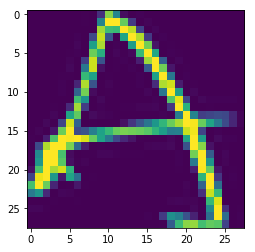

In [10]:
%matplotlib inline
plt.imshow(train_A[0,:,:])

Next we will check whether the data is balanced across classes

In [11]:
print('Checking number of images per class...')
for letter in train_datasets:
    file = open(letter, 'rb')
    dataset = pickle.load(file)
    print(letter + ' size: ' + str(dataset.shape[0]))
for letter in test_datasets:
    file = open(letter, 'rb')
    dataset = pickle.load(file)
    print(letter + ' size: ' + str(dataset.shape[0]))

Checking number of images per class...
notMNIST_large/A.pickle size: 52909
notMNIST_large/B.pickle size: 52911
notMNIST_large/C.pickle size: 52912
notMNIST_large/D.pickle size: 52911
notMNIST_large/E.pickle size: 52912
notMNIST_large/F.pickle size: 52912
notMNIST_large/G.pickle size: 52912
notMNIST_large/H.pickle size: 52912
notMNIST_large/I.pickle size: 52912
notMNIST_large/J.pickle size: 52911
notMNIST_small/A.pickle size: 1872
notMNIST_small/B.pickle size: 1873
notMNIST_small/C.pickle size: 1873
notMNIST_small/D.pickle size: 1873
notMNIST_small/E.pickle size: 1873
notMNIST_small/F.pickle size: 1872
notMNIST_small/G.pickle size: 1872
notMNIST_small/H.pickle size: 1872
notMNIST_small/I.pickle size: 1872
notMNIST_small/J.pickle size: 1872


Merge and prune the training data as needed. Depending on computer setup, it might not be able to fit it all in memory, so tune train_size as needed. The labels will be stored into a separate array of integers 0 through 9.

Also creating a validation dataset for hyperparameter tuning.

In [96]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Because it is important to have labels shuffled well so that training and test distributions match, we will randomize the data:

In [13]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

...and to check the above randomizing process:

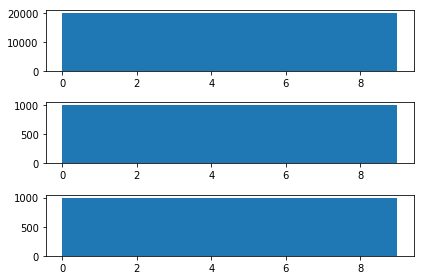

In [14]:
fig, ax = plt.subplots(3, 1)
ax[0].hist(train_labels, 10)
ax[1].hist(test_labels, 10)
ax[2].hist(valid_labels, 10)
fig.tight_layout()

Then saving the data for re-use:

In [15]:
pickle_file = 'notMNIST.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [16]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800506


This dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set.

Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it. 

The below measures how much overlap there is between training, validation and test samples.

In [17]:
train_dataset.flags.writeable = False
valid_dataset.flags.writeable = False
test_dataset.flags.writeable = False

train_hash = [hash(e.tobytes()) for e in train_dataset]
valid_hash = [hash(e.tobytes()) for e in valid_dataset]
test_hash = [hash(e.tobytes()) for e in test_dataset]

unique_train_hash = set(train_hash)
valid_overlap = unique_train_hash.intersection(set(valid_hash))
test_overlap = unique_train_hash.intersection(set(test_hash))

print('Duplicates inside training set: ', len(train_hash) - len(unique_train_hash))
print('Duplicates between training and validation: ', len(valid_overlap))
print('Duplicates between training and test: ', len(test_overlap))

Duplicates inside training set:  12682
Duplicates between training and validation:  942
Duplicates between training and test:  1116


_____________
### Training the Model(s)
_____________

### Using Logistic Regression

Doing a quick & dirty testing of the data on a logistic regression model from sci-kit learn.  I'll be using 50, 100, 1000, and 5000 training samples.

In [19]:
from sklearn.linear_model import LogisticRegression

train_sample = train_dataset[:5000,:,:]
train_sample_labels = train_labels[:5000]

(samples, width, height) = train_sample.shape
train_sample = np.reshape(train_sample, (samples, width * height))

(samples, width, height) = test_dataset.shape
test_dataset_reshaped = np.reshape(test_dataset, (samples, width * height))

model = LogisticRegression(penalty='l2', C=1.0)
model.fit(train_sample, train_sample_labels)

train_score = model.score(train_sample, train_sample_labels)
test_score = model.score(test_dataset_reshaped, test_labels)
print('Training score = ', train_score)
print('Test score = ', test_score)

Training score =  0.9454
Test score =  0.8481


_________________
### Using Multinomial Logistic Regression with Simple Gradient Descent

First going to train a multinomial logistic regression using simple gradient descent.

TensorFlow works like this:

- First you describe the computation that you want to see performed: what the inputs, the variables, and the operations look like. These get created as nodes over a computation graph. This description is all contained within the block below:

> with graph.as_default():
>    ...

- Then you can run the operations on this graph as many times as you want by calling session.run(), providing it outputs to fetch from the graph that get returned. This runtime operation is all contained in the block below:

> with tf.Session(graph=graph) as session:
>    ...

Loading all the data into TensorFlow and build the computation graph corresponding to the training:

In [61]:
# With gradient descent training, even this much data is prohibitive.
# Subset the training data for faster turnaround.
train_subset = 10000

graph = tf.Graph()
with graph.as_default():

  # Input data.
  # Load the training, validation and test data into constants that are
  # attached to the graph.
  tf_train_dataset = tf.constant(train_dataset[:train_subset, :])
  tf_train_labels = tf.constant(train_labels[:train_subset])
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  # These are the parameters that we are going to be training. The weight
  # matrix will be initialized using random valued following a (truncated)
  # normal distribution. The biases get initialized to zero.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  # We multiply the inputs with the weight matrix, and add biases. We compute
  # the softmax and cross-entropy (it's one operation in TensorFlow, because
  # it's very common, and it can be optimized). We take the average of this
  # cross-entropy across all training examples: that's our loss.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels))
  
  # Optimizer.
  # We are going to find the minimum of this loss using gradient descent.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  # These are not part of training, but merely here so that we can report
  # accuracy figures as we train.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

Running this computation and iterate:

In [63]:
num_steps = 801

def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

with tf.Session(graph=graph) as session:
  # This is a one-time operation which ensures the parameters get initialized as
  # we described in the graph: random weights for the matrix, zeros for the
  # biases. 
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    # Run the computations. We tell .run() that we want to run the optimizer,
    # and get the loss value and the training predictions returned as numpy
    # arrays.
    _, l, predictions = session.run([optimizer, loss, train_prediction])
    if (step % 100 == 0):
      print('Loss at step %d: %f' % (step, l))
      print('Training accuracy: %.1f%%' % accuracy(
        predictions, train_labels[:train_subset, :]))
      # Calling .eval() on valid_prediction is basically like calling run(), but
      # just to get that one numpy array. Note that it recomputes all its graph
      # dependencies.
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Loss at step 0: 15.848520
Training accuracy: 10.5%
Validation accuracy: 10.9%
Loss at step 100: 2.336076
Training accuracy: 72.0%
Validation accuracy: 71.2%
Loss at step 200: 1.879355
Training accuracy: 74.7%
Validation accuracy: 73.2%
Loss at step 300: 1.629327
Training accuracy: 75.9%
Validation accuracy: 74.1%
Loss at step 400: 1.460868
Training accuracy: 76.8%
Validation accuracy: 74.3%
Loss at step 500: 1.336191
Training accuracy: 77.3%
Validation accuracy: 74.4%
Loss at step 600: 1.238693
Training accuracy: 77.9%
Validation accuracy: 74.7%
Loss at step 700: 1.159979
Training accuracy: 78.3%
Validation accuracy: 74.9%
Loss at step 800: 1.094881
Training accuracy: 78.7%
Validation accuracy: 75.1%
Test accuracy: 82.3%


In [117]:
plt.scatter(step,accuracy(test_prediction.eval()))

AttributeError: 'int' object has no attribute 'graph'

_________________
### Using Multinomial Logistic Regression with Stochastic Gradient Descent

Switching to stochastic gradient descent training instead, which is much faster.

The graph will be similar, except that instead of holding all the training data into a constant node, we create a Placeholder node which will be fed actual data at every call of sesion.run().

In [65]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

...and running the model:

In [66]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Minibatch loss at step 0: 20.116461
Minibatch accuracy: 7.0%
Validation accuracy: 10.4%
Minibatch loss at step 500: 1.554421
Minibatch accuracy: 78.1%
Validation accuracy: 75.8%
Minibatch loss at step 1000: 1.610369
Minibatch accuracy: 74.2%
Validation accuracy: 76.6%
Minibatch loss at step 1500: 1.501733
Minibatch accuracy: 75.0%
Validation accuracy: 77.1%
Minibatch loss at step 2000: 1.020333
Minibatch accuracy: 83.6%
Validation accuracy: 77.8%
Minibatch loss at step 2500: 1.166822
Minibatch accuracy: 69.5%
Validation accuracy: 77.8%
Minibatch loss at step 3000: 0.928347
Minibatch accuracy: 77.3%
Validation accuracy: 78.7%
Test accuracy: 85.3%


 _______________________________________________

### Using a Neural Network from TensorFlow

Since the above works, I'll move on to the harder part of using more complicated models in TensorFlow.

In [39]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

First reload the data we generated in 1_notmnist.ipynb.

In [53]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:

- data as a flat matrix
- labels as float 1-hot encodings

In [54]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
    # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


Turn the logistic regression example with SGD into a 1-hidden layer neural network with rectified linear units (nn.relu()) and 1024 hidden nodes. This model should improve validation / test accuracy.

In [60]:
batch_size = 128
hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():
    
    # Input data. For the training data, use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # Variables.
    weights_1 = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_nodes]))
    biases_1 = tf.Variable(tf.zeros([hidden_nodes]))
    weights_2 = tf.Variable(tf.truncated_normal([hidden_nodes, num_labels]))
    biases_2 = tf.Variable(tf.zeros([num_labels]))
    
    # Training computation.
    def forward_prop(input):
        h1 = tf.nn.relu(tf.matmul(input, weights_1) + biases_1)
        return tf.matmul(h1, weights_2) + biases_2
    
    logits = forward_prop(tf_train_dataset)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels))
    
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(forward_prop(tf_valid_dataset))
    test_prediction = tf.nn.softmax(forward_prop(tf_test_dataset))

Running the model...

In [59]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Minibatch loss at step 0: 450.136322
Minibatch accuracy: 3.1%
Validation accuracy: 39.1%
Minibatch loss at step 500: 22.900543
Minibatch accuracy: 81.2%
Validation accuracy: 78.5%
Minibatch loss at step 1000: 16.283443
Minibatch accuracy: 78.1%
Validation accuracy: 81.1%
Minibatch loss at step 1500: 42.885845
Minibatch accuracy: 72.7%
Validation accuracy: 76.3%
Minibatch loss at step 2000: 4.747465
Minibatch accuracy: 83.6%
Validation accuracy: 80.4%
Minibatch loss at step 2500: 10.426809
Minibatch accuracy: 76.6%
Validation accuracy: 81.9%
Minibatch loss at step 3000: 1.828506
Minibatch accuracy: 83.6%
Validation accuracy: 82.5%
Test accuracy: 88.8%


_________________
### Using Regularization to Improve Model

Reloading the notMNIST data:

In [68]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models undergoing training:

- data as a flat matrix
- labels as float 1-hot encoding

In [69]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 2 to [0.0, 1.0, 0.0 ...], 3 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [71]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

Introducing and tuning L2 regularization for neural network model.  L2 amounts to adding a penalty on the norm of the weights to the loss. 

(In TensorFlow, you can compute the L2 loss for a tensor t using nn.l2_loss(t). ) 

The right amount of regularization should improve validation / test accuracy.



In [72]:
batch_size = 128
hidden_nodes = 1024
learning_rate = 0.5
beta = 0.005

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights_1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, hidden_nodes]))
  biases_1 = tf.Variable(tf.zeros([hidden_nodes]))
  weights_2 = tf.Variable(
    tf.truncated_normal([hidden_nodes, num_labels]))
  biases_2 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  def forward_prop(input):
    h1 = tf.nn.relu(tf.matmul(input, weights_1) + biases_1)
    return tf.matmul(h1, weights_2) + biases_2
  
  logits = forward_prop(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels))

  # Add the regularization term to the loss.
  loss += beta * (tf.nn.l2_loss(weights_1) + tf.nn.l2_loss(weights_2))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(forward_prop(tf_valid_dataset))
  test_prediction = tf.nn.softmax(forward_prop(tf_test_dataset))

In [73]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Minibatch loss at step 0: 1940.657715
Minibatch accuracy: 8.6%
Validation accuracy: 23.1%
Minibatch loss at step 500: 128.033722
Minibatch accuracy: 84.4%
Validation accuracy: 81.1%
Minibatch loss at step 1000: 10.994852
Minibatch accuracy: 85.2%
Validation accuracy: 85.6%
Minibatch loss at step 1500: 1.626345
Minibatch accuracy: 78.9%
Validation accuracy: 85.2%
Minibatch loss at step 2000: 0.674302
Minibatch accuracy: 89.1%
Validation accuracy: 85.0%
Minibatch loss at step 2500: 0.675410
Minibatch accuracy: 82.0%
Validation accuracy: 85.3%
Minibatch loss at step 3000: 0.622382
Minibatch accuracy: 86.7%
Validation accuracy: 85.7%
Test accuracy: 91.5%


Demonstrating an extreme case of overfitting by restricting training data to just a few batches:

In [75]:
train_dataset_restricted = train_dataset[:3000, :]
train_labels_restricted = train_labels[:3000, :]

num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels_restricted.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset_restricted[offset:(offset + batch_size), :]
    batch_labels = train_labels_restricted[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Minibatch loss at step 0: 1923.588867
Minibatch accuracy: 11.7%
Validation accuracy: 30.7%
Minibatch loss at step 500: 128.198792
Minibatch accuracy: 99.2%
Validation accuracy: 80.2%
Minibatch loss at step 1000: 10.760891
Minibatch accuracy: 99.2%
Validation accuracy: 83.1%
Minibatch loss at step 1500: 1.275869
Minibatch accuracy: 100.0%
Validation accuracy: 83.2%
Minibatch loss at step 2000: 0.456523
Minibatch accuracy: 100.0%
Validation accuracy: 83.0%
Minibatch loss at step 2500: 0.450665
Minibatch accuracy: 98.4%
Validation accuracy: 83.2%
Minibatch loss at step 3000: 0.394010
Minibatch accuracy: 99.2%
Validation accuracy: 83.1%
Test accuracy: 89.4%


_______
### Fixing Overfitting with Neural Drop-Out

To investigate how I can fix the above overfitting, I'll use dropout of the hidden layer of the neural network.  

(Note from TF site: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides nn.dropout() for that, but you have to make sure it's only inserted during training.)

In [76]:
batch_size = 128
hidden_nodes = 1024
learning_rate = 0.5
beta = 0.005

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)

  # Placeholder to control dropout probability.
  keep_prob = tf.placeholder(tf.float32)
  
  # Variables.
  weights_1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, hidden_nodes]))
  biases_1 = tf.Variable(tf.zeros([hidden_nodes]))
  weights_2 = tf.Variable(
    tf.truncated_normal([hidden_nodes, num_labels]))
  biases_2 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  def forward_prop(input):
    h1 = tf.nn.relu(tf.matmul(input, weights_1) + biases_1)
    
    # Add dropout to the hidden layer.
    drop = tf.nn.dropout(h1, keep_prob)
    
    return tf.matmul(drop, weights_2) + biases_2
  
  logits = forward_prop(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels))

  # Add the regularization term to the loss.
  loss += beta * (tf.nn.l2_loss(weights_1) + tf.nn.l2_loss(weights_2))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(forward_prop(tf_valid_dataset))
  test_prediction = tf.nn.softmax(forward_prop(tf_test_dataset))

In [77]:
train_dataset_restricted = train_dataset[:3000, :]
train_labels_restricted = train_labels[:3000, :]

num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, keep_prob: 1.0}
    feed_dict_w_drop = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, keep_prob: 0.5}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict_w_drop)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(feed_dict=feed_dict), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(feed_dict=feed_dict), test_labels))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Minibatch loss at step 0: 2078.843750
Minibatch accuracy: 12.5%
Validation accuracy: 31.6%
Minibatch loss at step 500: 129.101410
Minibatch accuracy: 75.8%
Validation accuracy: 81.2%
Minibatch loss at step 1000: 11.140911
Minibatch accuracy: 80.5%
Validation accuracy: 84.7%
Minibatch loss at step 1500: 1.698012
Minibatch accuracy: 78.1%
Validation accuracy: 84.6%
Minibatch loss at step 2000: 0.761447
Minibatch accuracy: 86.7%
Validation accuracy: 84.4%
Minibatch loss at step 2500: 0.795678
Minibatch accuracy: 80.5%
Validation accuracy: 84.4%
Minibatch loss at step 3000: 0.696603
Minibatch accuracy: 84.4%
Validation accuracy: 84.6%
Test accuracy: 90.5%


___________________
### Improving performance by implementing Learning Rate Decay & adding Multiple Layers to the model

(Note:  Best reported test accuracy from TF site using a deep network is 97.1%)

Another way to improve performance is to use learning rate decay:

>global_step = tf.Variable(0)  # count the number of steps taken.
>learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
>optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, >global_step=global_step)

Note that I added a 2nd hidden layer in the code but then commented it out because it made the performance worse, and my setup is too slow to spend time tuning hyperparameters.

In [85]:
batch_size = 128
hidden_nodes = 1024
hidden_nodes_2 = 500
beta = 0.005

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)

  # Placeholder to control dropout probability.
  keep_prob = tf.placeholder(tf.float32)
  
  # Variables.
  weights_1 = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_nodes]))
  biases_1 = tf.Variable(tf.zeros([hidden_nodes]))
  weights_2 = tf.Variable(tf.truncated_normal([hidden_nodes, num_labels]))
  biases_2 = tf.Variable(tf.zeros([num_labels]))
    
  # This is what the weights look like with an additional hidden layer.
  # weights_2 = tf.Variable(tf.truncated_normal([hidden_nodes, hidden_nodes_2]))
  # biases_2 = tf.Variable(tf.zeros([hidden_nodes_2]))
  # weights_3 = tf.Variable(tf.truncated_normal([hidden_nodes_2, num_labels]))
  # biases_3 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
#   def forward_prop(input):
#     h1 = tf.nn.relu(tf.matmul(input, weights_1) + biases_1)
#     drop = tf.nn.dropout(h1, keep_prob)
    
#     h2 = tf.nn.relu(tf.matmul(h1, weights_2) + biases_2)
#     drop = tf.nn.dropout(h2, keep_prob)
    
#     return tf.matmul(drop, weights_3) + biases_3

  def forward_prop(input):
    h1 = tf.nn.relu(tf.matmul(input, weights_1) + biases_1)
    drop = tf.nn.dropout(h1, keep_prob)
    
    return tf.matmul(drop, weights_2) + biases_2
  
  logits = forward_prop(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels))

  # Add the regularization term to the loss.
  # loss += beta * (tf.nn.l2_loss(weights_1) + tf.nn.l2_loss(weights_2) + tf.nn.l2_loss(weights_3))
  loss += beta * (tf.nn.l2_loss(weights_1) + tf.nn.l2_loss(weights_2))
  
  # Optimizer w/ learning rate decay.
  global_step = tf.Variable(0)
  learning_rate = tf.train.exponential_decay(0.5, global_step, 1000, 0.9)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(forward_prop(tf_valid_dataset))
  test_prediction = tf.nn.softmax(forward_prop(tf_test_dataset))

In [86]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, keep_prob: 1.0}
    feed_dict_w_drop = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, keep_prob: 0.5}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict_w_drop)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(feed_dict=feed_dict), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(feed_dict=feed_dict), test_labels))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Minibatch loss at step 0: 2093.174561
Minibatch accuracy: 12.5%
Validation accuracy: 40.8%
Minibatch loss at step 500: 137.011505
Minibatch accuracy: 81.2%
Validation accuracy: 82.4%
Minibatch loss at step 1000: 14.000149
Minibatch accuracy: 84.4%
Validation accuracy: 84.8%
Minibatch loss at step 1500: 2.313792
Minibatch accuracy: 78.9%
Validation accuracy: 84.8%
Minibatch loss at step 2000: 0.873355
Minibatch accuracy: 89.1%
Validation accuracy: 85.0%
Minibatch loss at step 2500: 0.799478
Minibatch accuracy: 82.0%
Validation accuracy: 84.9%
Minibatch loss at step 3000: 0.701796
Minibatch accuracy: 85.9%
Validation accuracy: 85.2%
Test accuracy: 91.1%


(Note: Since I can't realistically do multiple layers in a small enough time, I'll probably change the model to convolutional instead..?)

_______
### Turning the model into a Convolutional Neural Network

Again, I'll reload just in case problems arise...

In [97]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a TensorFlow-friendly shape:

- convolutions need the image data formatted as a cube (width by height by #channels)
- labels as float 1-hot encodings

In [99]:
image_size = 28
num_labels = 10
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28, 1) (200000, 10)
Validation set (10000, 28, 28, 1) (10000, 10)
Test set (10000, 28, 28, 1) (10000, 10)


In [100]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

Below is a small network with two convolutional layers, followed by one fully connected layer. Convolutional networks are more expensive computationally, so I'll limit its depth and number of fully connected nodes.

In [101]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer1_biases)
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer2_biases)
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [102]:
num_steps = 1001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 100 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Minibatch loss at step 0: 3.206704
Minibatch accuracy: 6.2%
Validation accuracy: 10.0%
Minibatch loss at step 100: 0.713621
Minibatch accuracy: 87.5%
Validation accuracy: 71.5%
Minibatch loss at step 200: 0.391885
Minibatch accuracy: 93.8%
Validation accuracy: 76.9%
Minibatch loss at step 300: 1.073014
Minibatch accuracy: 62.5%
Validation accuracy: 78.6%
Minibatch loss at step 400: 0.829961
Minibatch accuracy: 81.2%
Validation accuracy: 80.6%
Minibatch loss at step 500: 0.548485
Minibatch accuracy: 87.5%
Validation accuracy: 80.6%
Minibatch loss at step 600: 0.529187
Minibatch accuracy: 81.2%
Validation accuracy: 81.3%
Minibatch loss at step 700: 0.422235
Minibatch accuracy: 87.5%
Validation accuracy: 81.6%
Minibatch loss at step 800: 0.942188
Minibatch accuracy: 75.0%
Validation accuracy: 82.3%
Minibatch loss at step 900: 1.245304
Minibatch accuracy: 68.8%
Validation accuracy: 82.6%
Minibatch loss at

The convolutional model above uses convolutions with stride 2 to reduce the dimensionality. Replace the strides by a max pooling operation (nn.max_pool()) of stride 2 and kernel size 2.

Note:  The "stride" is amount by which the filter shifts (convolves around the input volume)).  See tutorial on convolutional neural networks here: https://adeshpande3.github.io/A-Beginner%27s-Guide-To-Understanding-Convolutional-Neural-Networks-Part-2/

In [104]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
    pool = tf.nn.max_pool(conv, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(pool + layer1_biases)
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, 1, 1, 1], padding='SAME')
    pool = tf.nn.max_pool(conv, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(pool + layer2_biases)
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [105]:
num_steps = 1001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 100 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Minibatch loss at step 0: 2.801422
Minibatch accuracy: 12.5%
Validation accuracy: 10.0%
Minibatch loss at step 100: 0.829905
Minibatch accuracy: 50.0%
Validation accuracy: 71.8%
Minibatch loss at step 200: 0.444807
Minibatch accuracy: 87.5%
Validation accuracy: 76.7%
Minibatch loss at step 300: 0.942970
Minibatch accuracy: 68.8%
Validation accuracy: 78.8%
Minibatch loss at step 400: 0.683489
Minibatch accuracy: 81.2%
Validation accuracy: 82.0%
Minibatch loss at step 500: 0.516719
Minibatch accuracy: 87.5%
Validation accuracy: 81.8%
Minibatch loss at step 600: 0.405760
Minibatch accuracy: 93.8%
Validation accuracy: 81.2%
Minibatch loss at step 700: 0.368383
Minibatch accuracy: 81.2%
Validation accuracy: 80.1%
Minibatch loss at step 800: 0.873911
Minibatch accuracy: 68.8%
Validation accuracy: 83.6%
Minibatch loss at step 900: 1.202445
Minibatch accuracy: 75.0%
Validation accuracy: 83.5%
Minibatch loss a

_______________
### Adding Dropout & Learning Rate Decay to Convolutional Neural Network

In [107]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)

  # Placeholder to control dropout probability.
  keep_prob = tf.placeholder(tf.float32)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
    pool = tf.nn.max_pool(conv, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(pool + layer1_biases)
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, 1, 1, 1], padding='SAME')
    pool = tf.nn.max_pool(conv, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(pool + layer2_biases)
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    drop = tf.nn.dropout(hidden, keep_prob)
    return tf.matmul(drop, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [108]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, keep_prob: 1.0}
    feed_dict_w_drop = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, keep_prob: 0.5}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict_w_drop)
    if (step % 100 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(feed_dict=feed_dict), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(feed_dict=feed_dict), test_labels))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Minibatch loss at step 0: 4.437622
Minibatch accuracy: 6.2%
Validation accuracy: 10.0%
Minibatch loss at step 100: 2.261981
Minibatch accuracy: 18.8%
Validation accuracy: 10.6%
Minibatch loss at step 200: 1.700169
Minibatch accuracy: 43.8%
Validation accuracy: 43.2%
Minibatch loss at step 300: 1.459558
Minibatch accuracy: 43.8%
Validation accuracy: 67.0%
Minibatch loss at step 400: 1.515023
Minibatch accuracy: 50.0%
Validation accuracy: 76.2%
Minibatch loss at step 500: 0.649079
Minibatch accuracy: 75.0%
Validation accuracy: 76.7%
Minibatch loss at step 600: 0.994361
Minibatch accuracy: 68.8%
Validation accuracy: 80.0%
Minibatch loss at step 700: 0.643727
Minibatch accuracy: 75.0%
Validation accuracy: 80.3%
Minibatch loss at step 800: 1.171040
Minibatch accuracy: 75.0%
Validation accuracy: 81.7%
Minibatch loss at step 900: 1.202930
Minibatch accuracy: 68.8%
Validation accuracy: 81.2%
Minibatch loss at